# Visualizing Data From Ocean Gliders
## EDS 220 Fall 2021

(This notebook is adapted from a tutorial on glider data access and visualization at:

https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access_notebooks/2016-11-15-glider_data_example.html)

### Ocean Gliders: What Are They?

This notebook focuses on using data from _ocean gliders_: semi-autonomous samplers which 'dive' through the water column and conduct measurements of various oceanographic quantities. There are several different types of gliders; here is a schematic summarizing the typical action of a glider (in this case, a "Seaglider" brand instrument):

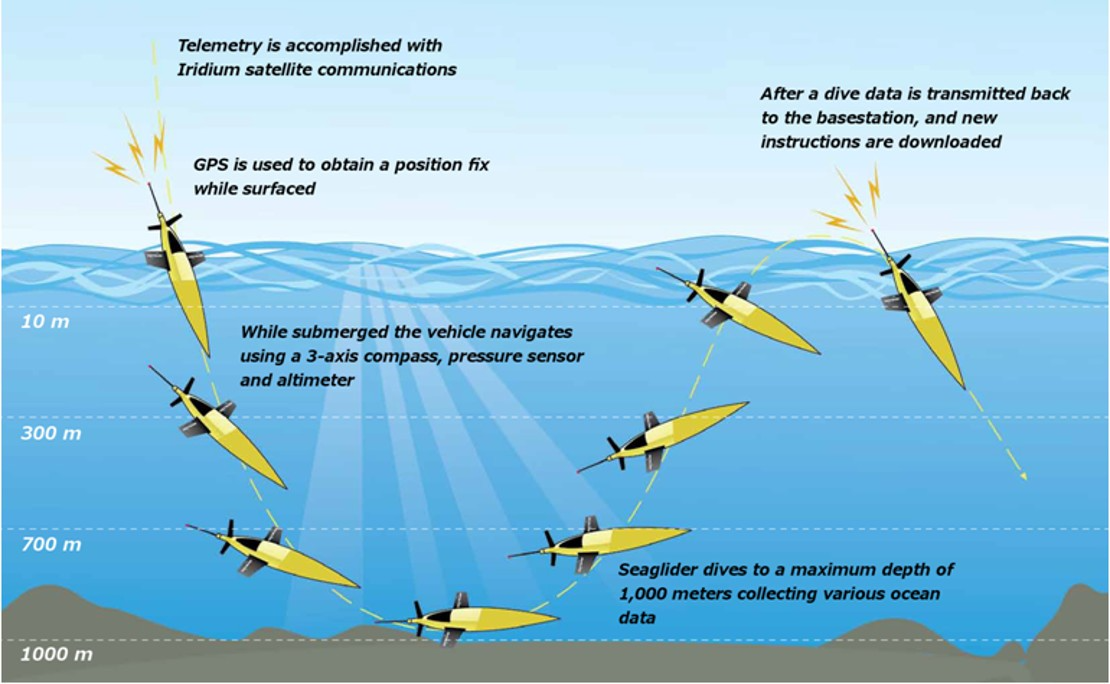

There are also several different data portals at which one can access data from gliders. A comprehensive data source is hosted by the U.S. Integrated Ocean Observing System, or IOOS:

https://ioos.noaa.gov/

IOOS provides a centralized hosting repository for glider data, including a set of standardized metadata fields. There is also an interactive map of gliders currently in the ocean:

https://gliders.ioos.us/map/

Many examples of how to access and manipulate IOOS data (including but not limited to gliders) can also be found at the IOOS "Code Lab":

https://ioos.github.io/ioos_code_lab/content/intro.html

### Accessing Glider Data: ERDDAP


Here, we'll take advantage of the NOAA Environmental Research Division Data Access Program, or ERDDAP, to access glider data. ERDDAP is a method developed to provide access to data hosted in many different formats: you can think of it as a sort of 'wrapper' or API to interface with OpenDAP or other data access protocols. A more detailed explanation can be found here:

https://gliders.ioos.us/erddap/index.html

First, as usual, let's load all the Python packages needed for this exercise:

In [21]:
# Configure environment
import requests
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
import pandas as pd
import iris
import numpy.ma as ma
import folium
from palettable import cmocean
import pickle

Now to actually access the data, we'll use the Python `requests` package, which is a Python HTTP library designed to create human-readable HTTP queries. This will allow us to search within the base location for the IOOS glider deployments, and then parse the resulting JSON structure to return various quantities of interest:

In [17]:
# Specify URL to query for available datasets
url = "http://data.ioos.us/gliders/providers/api/deployment"

# Perform request, return JSON
response = requests.get(url)
res = response.json()

print(f"Found {res['num_results']} deployments!")

Found 1058 deployments!


*Tip: don't try to print out the entire set of JSON data at once*, this will likely crash your computer!

Now let's say we'd like to look at a particular deployment. This can be accomplished by taking the `res` object containing the JSON, and extracting the "results" variable within it. From there, we can pick out an arbitrary glider mission.

Some good options for doing this:
- most recent deployment: can be found using -1 as the index within "deployments"
- oldest deployment: index 0
- or just play around with it!

In [18]:
# Store results of JSON query: each is an individual deployment
deployments = res["results"]

# Extract information associated with the last entry
deployment = deployments[100]

# Take a look at the data
deployment

{'archive_safe': True,
 'attribution': 'Funding provided by the National Science Foundation. Glider deployed by OOI Coastal Endurance personnel at Oregon State University',
 'checksum': '02167511637e8bca2e232873bb478b97',
 'completed': True,
 'compliance_check_passed': False,
 'created': 1568063639186,
 'dap': 'http://gliders.ioos.us/thredds/dodsC/deployments/OOI-CE/ce_311-20190703T1802/ce_311-20190703T1802.nc3.nc',
 'delayed_mode': False,
 'deployment_date': 1562176920000,
 'deployment_dir': 'OOI-CE/ce_311-20190703T1802',
 'erddap': 'http://gliders.ioos.us/erddap/tabledap/ce_311-20190703T1802.html',
 'estimated_deploy_date': None,
 'estimated_deploy_location': None,
 'glider_name': 'ce_311',
 'id': '5d76c09798723c0ecce4d0a5',
 'iso': 'http://gliders.ioos.us/erddap/tabledap/ce_311-20190703T1802.iso19115',
 'latest_file': 'ce_311_20190910T115756Z_rt.nc',
 'latest_file_mtime': 1571424702901,
 'name': 'ce_311-20190703T1802',
 'operator': 'OOI-CE',
 'sos': 'http://gliders.ioos.us/thredds/s

### Reading in Data with Iris

OK, so now we've got our deployment of interest. How do we actually go about taking a look at the data? There are many options for doing this, including:
- Reading in as a Pandas dataframe
- Loading into an Iris data cube
- Using xarray to read in as a Dataset

Here, we'll use the `iris` package, to learn about a new method for data I/O. Iris, similar to xarray, is a package designed to layer metadata appropriate for environmental datasets onto data arrays (numpy is a core part of iris). Iris is quite strict about forcing data to follow the [CF conventions](http://cfconventions.org/) for metadata, which is good in the sense that the resulting datasets will have extremely robust and reliable metadata, but can be somewhat tricky to read in data at times.

The following code chunk isolates the URL associated with the particular DAP endpoint for the glider deployment we picked above, then loads it into an Iris _data cube_. Note the need to include the `#fillmismatch` flag in the URL - if we do not include this, the data extraction will fail due to the need for strict adherence to CF conventions!

In [19]:
# Grab appropriate URL for our deployment
url = deployment["dap"]

# Read into an Iris data cube
glider = iris.load_raw(url+"#fillmismatch")

# Take a look at the results
print(glider)

/Users/samstevenson/opt/anaconda3/envs/opendap_working/lib/python3.7/site-packages/iris/fileformats/cf.py:283: UserWarning: Missing CF-netCDF ancillary data variable 'profile_time', referenced by netCDF variable 'profile_id'
  warnings.warn(message % (name, nc_var_name))
/Users/samstevenson/opt/anaconda3/envs/opendap_working/lib/python3.7/site-packages/iris/fileformats/cf.py:1154: UserWarning: Ignoring variable 'radiation_wavelength' referenced by variable 'backscatter': Dimensions ('trajectory', 'profile', 'obs', 'maxStrlen64') do not span ('trajectory', 'profile', 'obs')
  warnings.warn(msg)


0: downwelling_photosynthetic_photon_spherical_irradiance_in_sea_water / (umol m-2 s-1) (-- : 1; -- : 2973; -- : 54)
1: time Variable Quality Flag / (no_unit) (-- : 1; -- : 2973; -- : 54)
2: sea_water_practical_salinity / (1)  (-- : 1; -- : 2973; -- : 54)
3: concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate / (ppb) (-- : 1; -- : 2973; -- : 54)
4: v Variable Quality Flag / (no_unit) (-- : 1; -- : 2973; -- : 54)
5: lon_uv Variable Quality Flag / (no_unit) (-- : 1; -- : 2973; -- : 54)
6: lat_uv Variable Quality Flag / (no_unit) (-- : 1; -- : 2973; -- : 54)
7: depth Variable Quality Flag / (no_unit) (-- : 1; -- : 2973; -- : 54)
8: sea_water_pressure / (dbar)         (-- : 1; -- : 2973; -- : 54)
9: Platform Metadata / (1)             (-- : 1; -- : 2973; -- : 54)
10: northward_sea_water_velocity / (m s-1) (-- : 1; -- : 2973)
11: longitude Variable Quality Flag / (no_unit) (-- : 1; -- : 2973; -- : 54)
12: sea_wate

In [22]:
# Save output for later
#with open('glider_deployment.pickle','wb') as f:
#    pickle.dump(glider,f)

In [ ]:
# Load in data from local repo if necessary
#with open('glider_deployment.pickle','rb') as f:
#    glider=pickle.load(f)

The metadata above are quite extensive! Many variables are available within the data cube. Note that the dimensions are not particularly well explained within the metadata - this will become more clear as we extract additional information from the cube.

Let's do exactly that, using the `extract_cube` method to grab the temperature measurements made by this glider:

In [23]:
# Extract temperature portion of data cube
temp = glider.extract_cube("sea_water_temperature")

# Print out metadata
print(temp)

sea_water_temperature / (Celsius)         (-- : 1; -- : 2973; -- : 54)
    Auxiliary coordinates:
        latitude                              x       x          -
        longitude                             x       x          -
        time                                  x       x          -
        depth                                 x       x          x
    Ancillary variables:
        sea_water_temperature status_flag     x       x          x
        sea_water_temperature status_flag     x       x          x
        sea_water_temperature status_flag     x       x          x
        sea_water_temperature status_flag     x       x          x
        sea_water_temperature status_flag     x       x          x
    Attributes:
        Conventions                       Unidata Dataset Discovery v1.0, COARDS, CF-1.6
        DODS.dimName                      source_file_strlen
        DODS.strlen                       35
        Easternmost_Easting               -124.10336098036207
 

Now we're seeing metadata that are more directly usable. In particular, note the information on coordinates: what is going on there? Let's explore this a bit more.

In [24]:
# Display coord method for temperature object
temp.coords

<bound method Cube.coords of <iris 'Cube' of sea_water_temperature / (Celsius) (-- : 1; -- : 2973; -- : 54)>>

The `coord` method takes several options. One useful feature is the ability to extract coordinates along a "best guess" axis; this saves you the trouble of matching a dimension name with a numerical dimension within a data matrix. For example, we can look at the coordinate along the X axis:

In [25]:
# Display X coordinate
temp.coord(axis="X")

AuxCoord(masked_array(data=[[-124.31215738, -124.31700148, -124.31799591, ...,
                    -125.9187239 , -125.91837305, -125.91525538]],
             mask=False,
       fill_value=1e+20), standard_name='longitude', units=Unit('degrees'), long_name='Profile Longitude', var_name='longitude', attributes={'_CoordinateAxisType': 'Lon', 'actual_range': array([-125.9187239 , -124.10336098]), 'colorBarMaximum': 180.0, 'colorBarMinimum': -180.0, 'comment': 'Value is interpolated to provide an estimate of the longitude at the mid-point of the profile.', 'ioos_category': 'Location', 'observation_type': 'calculated', 'platform': 'platform', 'precision': 5, 'valid_max': 180.0, 'valid_min': -180.0})

Now that we've gotten a bit of a handle on coordinates, we can go ahead and extract the rest of them! And, of course, the temperature data values themselves:

In [26]:
# Extract values of x, y, z, and t coordinates
# Longitude (X)
x = temp.coord(axis="X").points.squeeze()

# Latitude (Y)
y = temp.coord(axis="Y").points.squeeze()

# Depth (Z)
z = temp.coord(axis="Z").points.squeeze()

# Time (T)
t = temp.coord(axis="T")

# Temperature data
T = temp.data.squeeze()


### Visualize glider locations: folium

Now the data is read in, which means we can do cool things with it! One powerful tool is the `folium` package, which allows one to plot environmental data on top of an interactive basemap (think Google Earth Engine but with more customizability).

To plot the track of our glider deployment, we need to grab the arrays containing the time history of its location:

In [27]:
# Location of track center
location = y.mean(), x.mean()

# All locations visited by the glider
locations = list(zip(y, x))  

The below commands add the base map (here referred to as "tiles") to a folium Map object, then add markers for the start/end points of the track as well as a line connecting all locations visited:

In [28]:
# Find location of basemap tiles
tiles = (
    "http://services.arcgisonline.com/arcgis/rest/services/"
    "World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}"
)

# Create folium map object
m = folium.Map(location, tiles=tiles, attr="ESRI", zoom_start=7)

# Filled circular markers showing the start/end locations of the glider
folium.CircleMarker(locations[0], fill_color="green", radius=10).add_to(m)
folium.CircleMarker(locations[-1], fill_color="red", radius=10).add_to(m)

# Line connecting all glider locations
line = folium.PolyLine(
    locations=locations,
    color="orange",
    weight=8,
    opacity=0.6,
    popup="",
).add_to(m)

# Display map
m

### Make Vertical Cross-Section

Another common plot people make using glider data is a vertical cross-section of a data field (here, temperature) as a function of distance along the glider track. Let's try one!

First, let's define a function `distance` that simply calculates the total cumulative distance traveled at every x and y location visited by the glider. This uses the `dist` function in the seawater package:

In [41]:
# Function to calculate cumulative distance traveled
def distance(x, y, units="km"):
    # Calculate distance between consecutive points along the track
    dist, pha = sw.dist(x, y, units=units)
    
    # Return the sum of all distances
    return np.r_[0, np.cumsum(dist)]
    

Now we can go ahead and plot the result!

/Users/samstevenson/opt/anaconda3/envs/opendap_working/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


Text(0, 0.5, 'Depth (m)')

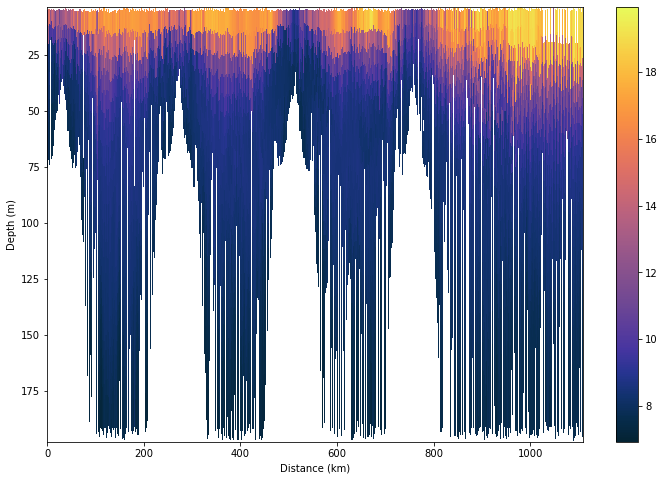

In [42]:
# Define a colormap that's good for temperature data
thermal = cmocean.sequential.Thermal_20.mpl_colormap

# Create a new figure and axis object
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# Plot results
dist = distance(x, y, units="km")
z = np.abs(z)
dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
cs = ax.pcolor(dist, z, T, cmap=thermal, snap=True)
cbar = fig.colorbar(cs)
ax.invert_yaxis()
    
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (m)")